# How does variance change in a categorical distribution when a category has no successes
Is subsampling negative examples for a categorical distribution washing away any distribution of the non-successful cases?

Hypotehsis: If you subsample a categorical distribution, you will not get the correct, or any, uncertainty in non-successful categories.

We have ten categories that is controlled by ten different propensities normalized by a softmax:

$$P( C = i | R ) = \frac{e^r_{i}}{\sum_{k=1}^{10} e^{r_k}}$$

for $i = 1,..,10$ and $r_i$ is the propensity/relevancy for each category.

We conduct the following experiment:
- The likelihood will only have observations with successes on one category.
- We set a weak prior $N(0,3)$ on all relevancy scores $r_i$
- The numbers of observations for category $i=1$ ranges from 0 to 5000.
- For simplicity we approximate the true posterior with a Normal distributions. This is ok as we do not care explicitly about the distribution, but the magnitude of the uncertainties.
- We use Variational Inference with ELBO loss to approximate the posterior. 
- Each propensity is approximated by a $N(\alpha_k, \beta_k)$ distribution where $\alpha$ and $\beta$ are variational parameters

*Remark on exact solutions*: Tried to develop some simple toy examples here, but it quickly became intractable.


In [1]:
import pyro
import pyro.distributions as dist
from pyro import plate
import torch
import torch.distributions.constraints as constraints
import pyro.optim as optim
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# set up the optimizer
OBS_TESTS = [1,10, 20 ,100, 200, 500, 1000,2000,3000,4000,5000, 10000,11000,12000]
Apar = torch.zeros(len(OBS_TESTS),10)
Bpar = torch.zeros(len(OBS_TESTS),10)
for k, num_obs in enumerate(OBS_TESTS):
    def guide():
        A = pyro.param("Apar", torch.zeros(10))
        B = pyro.param("Bpar", torch.ones(10), constraint = constraints.positive)
        r = torch.zeros(10)
        for i in plate("R", 10):
            r[i] = pyro.sample(f"r_{i}", dist.Normal(A[i],B[i]))
    def model():
        r = torch.zeros(10)
        for i in plate("R", 10):
            r[i] = pyro.sample(f"r_{i}", dist.Normal(0,3))
        softmax = torch.exp(r) / torch.exp(r).sum()
        with plate("data", num_obs) as i:
            obs = pyro.sample("obs",dist.Categorical(probs=softmax), obs = torch.zeros(len(i)).long())

    pyro.clear_param_store()
    adam_params = {"lr": 0.05}
    optimizer = Adam(adam_params)

    # setup the inference algorithm
    svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

    num_steps = 1000
    loss = torch.zeros(num_steps)

    for i in range(len(loss)):
        loss[i] = svi.step()

    Apar[k,] = pyro.param("Apar")
    Bpar[k,] = pyro.param("Bpar")

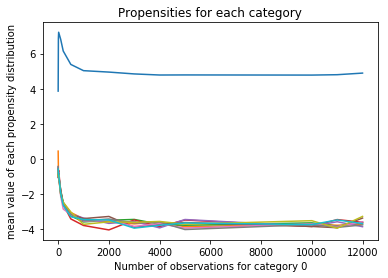

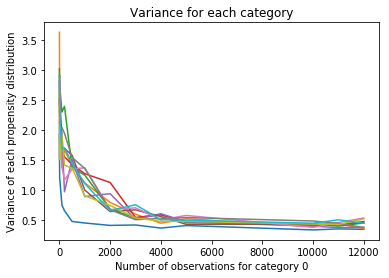

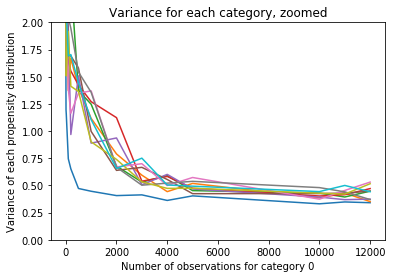

In [5]:
_ = plt.plot(OBS_TESTS, Apar.detach().numpy())
plt.title("Propensities for each category")
plt.xlabel("Number of observations for category 0")
plt.ylabel("mean value of each propensity distribution")
plt.show()
plt.title("Variance for each category")
plt.xlabel("Number of observations for category 0")
plt.ylabel("Variance of each propensity distribution")
_ = plt.plot(OBS_TESTS,Bpar.detach().numpy())
plt.show()
plt.title("Variance for each category, zoomed")
plt.xlabel("Number of observations for category 0")
plt.ylabel("Variance of each propensity distribution")
_ = plt.plot(OBS_TESTS,Bpar.detach().numpy())
_ = plt.ylim(0,2)

## Analysis and conclusions
- The mean relevancy parameter is clearly higher for the successful category, as should be expected.
- The uncertainties in the Variance of each category, it decreases a bit slower but at the same rate as the successful category.

This simulation indicates that it a bad idea to subsample items as candidates in a categorical distribution if no information actually have been given about the category. This will reduce the uncertainties for those being subsampled.